<a href="https://colab.research.google.com/github/diogocezar/phd-machine-learning-lab3/blob/master/machine_learning_lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LABORATÓRIO 3

## INTRODUÇÃO

A ideia deste notebook é criar um experimento para que a atividade de laboratório 3 da disciplina de aprenziagem de máquina.

### ENUNCIADO

Para esse laboratório considere a base de dados de meses do ano (12 classes) apresentado nas práticas de Deep Learning.

1. Implemente funções para aumentar o número de amostras do conjunto de TREINAMENTO (Data Augmentation);

2. Implemente duas redes neurais convolucionais: (a) LeNet 5 [Yann LeCun (1998)]; (b) CNN de sua escolha;

3. Escreva um breve relatório que:
  - Descreva as CNNs utilizadas e as funções de Data Augmentation;
  - Compare o desempenho dessas redes variando os diferentes parâmetros apresentados em aula. Realize treinamentos com e sem Data Augmentation. Analise os resultados obtidos nos diferentes experimentos apresentando suas conclusões (apresente gráficos e matriz de confusão);
  - Repita os experimentos e análises utilizando 2 redes pré-treinadas na ImageNet (Transfer Learning/Fine-Tuning). Utilize essas redes para gerar vetores de características, realizando a classificação em outro classificador (Ex: SVM).


### LINKS ÚTEIS

- https://github.com/TaavishThaman/LeNet-5-with-Keras/blob/master/lenet_5.py
- https://engmrk.com/lenet-5-a-classic-cnn-architecture/
- https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
- https://engmrk.com/alexnet-implementation-using-keras/
- https://cs231n.github.io/convolutional-networks/
- https://github.com/eweill/keras-deepcv/blob/master/models/classification/alexnet.py
- https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

# PREPARAÇÕES

## HABILITANDO A GPU

Neste ponto se importa o tensorflow e executa-se uma verificação para analisar se a máquina que executará os scripts utiliza o processamento em GPU.

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print('HABILITANDO GPU - DONE')

Found GPU at: /device:GPU:0
HABILITANDO GPU - DONE


Caso a saída seja: `Found...` então, pode-se executar a próxia linha, que habilita a execução.

In [3]:
!nvidia-smi

Wed Sep  2 13:29:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    34W / 250W |    359MiB / 16280MiB |      6%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## IMPORTANDO OS DADOS DO GITHUB

Neste ponto, utiliza-se o repositório do GitHub listado abaixo para obter o .zip com as informações a serem utilizadas no experimento.

Os comandos na sequência removem as pastas desnecessárias deixando apenas os arquivos importantes para a execução dos próximos passos.

In [4]:
!git clone --single-branch --branch data https://github.com/diogocezar/phd-machine-learning-lab3 ./data

fatal: destination path './data' already exists and is not an empty directory.


## REALIZANDO OS IMPORTS

Aqui reliza-se as importações dos pacotes que serão utilizados nos experimentos.

In [5]:
import numpy as np
from numpy import expand_dims
import cv2
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import f1_score as sklearn_f1_score
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix

from PIL import Image

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, BatchNormalization
from keras.models import Model
from keras.regularizers import l2

from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

import os
import time
import glob
from tempfile import mkstemp
from shutil import move, copymode
from os import fdopen, remove

print('REALIZANDO OS IMPORTS - DONE')

REALIZANDO OS IMPORTS - DONE


## DEFININDO AS ENTRADAS

Então, é necessário definir os arquivos de entrada obtidos através do GitHub.

In [6]:
TRAIN_FILE = "./data/train.txt"
TEST_FILE = "./data/test.txt"

print('DEFININDO AS ENTRADAS - DONE')

DEFININDO AS ENTRADAS - DONE


## DEFININDO AS FUNÇÕES AUXILIARES

Neste ponto são definidas as funções auxiliares para a execução dos experimentos.**negrito**

In [7]:
def resize_data(data, size, convert):
	if convert:
		data_upscaled = np.zeros((data.shape[0], size[0], size[1], 3))
	else:
		data_upscaled = np.zeros((data.shape[0], size[0], size[1]))
	for i, img in enumerate(data):
		large_img = cv2.resize(img, dsize=(size[1], size[0]), interpolation=cv2.INTER_CUBIC)
		data_upscaled[i] = large_img
	return data_upscaled

def load_images(image_paths, convert=False):
	x = []
	y = []
	for image_path in image_paths:
		path, label = image_path.split(' ')
		path= './data/data/' + path
		if convert:
			image_pil = Image.open(path).convert('RGB') 
		else:
			image_pil = Image.open(path).convert('L')
		img = np.array(image_pil, dtype=np.uint8)
		x.append(img)
		y.append([int(label)])
	x = np.array(x)
	y = np.array(y)
	if np.min(y) != 0: 
		y = y-1
	return x, y

def load_dataset(train_file, test_file, resize, convert=False, size=(224,224)):
	arq = open(train_file, 'r')
	texto = arq.read()
	train_paths = texto.split('\n')
	print ('Size:', size)
	train_paths.remove('')
	train_paths.sort()
	print ("Loading training set...")
	x_train, y_train = load_images(train_paths, convert)
	arq = open(test_file, 'r')
	texto = arq.read()
	test_paths = texto.split('\n')
	test_paths.remove('')
	test_paths.sort()
	print ("Loading testing set...")
	x_test, y_test = load_images(test_paths, convert)
	if resize:
		print ("Resizing images...")
		x_train = resize_data(x_train, size, convert)
		x_test = resize_data(x_test, size, convert)
	if not convert:
		x_train = x_train.reshape(x_train.shape[0], size[0], size[1], 1)
		x_test = x_test.reshape(x_test.shape[0], size[0], size[1], 1)
	print (np.shape(x_train))
	return (x_train, y_train), (x_test, y_test)
 
def generate_labels(x_test, y_test):
  labels = []
  for i in range(len(x_test)):
    labels.append(y_test[i][0])
  return labels

def normalize_images(x):
  x = x.astype('float32')
  x /= 255
  return x

def convert_vector(x, num_classes):
  return keras.utils.to_categorical(x, num_classes)

def fit_model(model, x_train, y_train, x_test, y_test, epochs, batch_size=128, verbose=1):
  return model.fit(x=x_train, y=y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), verbose=verbose)

def get_confusion_matrix(model, x_test, labels):
  pred = []
  y_pred = model.predict_classes(x_test)
  for i in range(len(x_test)):
    pred.append(y_pred[i])
  return confusion_matrix(labels, pred)

def plot_graphs(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  plt.figure(figsize=(12,9))
  plt.plot(epochs, acc, 'b', label='Acurácia do treinamento')
  plt.plot(epochs, val_acc, 'r', label='Acurácia da validação')
  plt.title('Acurácia do treinamento e validação')
  plt.legend()
  plt.figure(figsize=(12,9))
  plt.plot(epochs, loss, 'b', label='Perda do treinamento')
  plt.plot(epochs, val_loss, 'r', label='Perda da validação')
  plt.title('Perda do treinamento e validação')
  plt.legend()
  plt.show()

def extract_features(input_file, output_file, img_rows, img_cols, dir_dataset):
	file_input = open (input_file, 'r')
	input = file_input.readlines()
	file_input.close()
	output = open(output_file, 'w')
	model = InceptionV3(weights='imagenet', include_top=False)
	for i in input:
		sample_name, sample_class = i.split()
		img_path = dir_dataset + sample_name
		print(img_path)
		img = image.load_img(img_path, target_size=(img_rows,img_cols))
		img_data = image.img_to_array(img)
		img_data = np.expand_dims(img_data, axis=0)
		img_data = preprocess_input(img_data)
		inception_features = model.predict(img_data)
		features_np = np.array(inception_features)
		features_np = features_np.flatten()
		output.write(sample_class+' ')
		for j in range (features_np.size):
			output.write(str(j+1)+':'+str(features_np[j])+' ')
		output.write('\n')
	print(features_np.size)
	output.close()
 
def round_float(value):
	return float("{:.3f}".format(value))
 
def get_time():
    return time.time()

def get_time_diff(start_time):
    end_time = time.time()
    return round_float(end_time - start_time)

def plot_confusion_matrix(cm):
	fig = plt.figure(figsize=(10,10))
	ax = fig.add_subplot(111)
	cax = ax.matshow(cm)
	for (x, y), value in np.ndenumerate(cm):
		plt.text(x, y, f"{value:.0f}", va="center", ha="center")
	plt.title('Matrix de Confusão')
	fig.colorbar(cax)
	plt.xlabel('Predicted')
	plt.ylabel('True')
	plt.show()

print('DEFININDO AS FUNÇÕES AUXILIARES - DONE')


DEFININDO AS FUNÇÕES AUXILIARES - DONE


# DEFINIÇÃO DOS MODELOS

In [8]:
def lenet5(img_rows, img_cols, num_classes):
  model = Sequential()
  model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(img_rows,img_cols,3), padding="same"))
  model.add(AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))
  model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
  model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
  model.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
  model.add(Flatten())
  model.add(Dense(84, activation='tanh'))
  model.add(Dense(num_classes, activation='softmax'))
  return model

def default(img_rows, img_cols, num_classes):
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_rows,img_cols,3)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  return model

## Se for criar outro modelo crie uma nova função e novos trechos de execução no Colab

print('DEFINIÇÃO DOS MODELOS - DONE')

DEFINIÇÃO DOS MODELOS - DONE


# LENET 5 - SEM DATA AUGMENTATION

## EXECUÇÃO

Size: (20, 20)
Loading training set...
Loading testing set...
Resizing images...
(1578, 20, 20, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 20, 6)         456       
_________________________________________________________________
average_pooling2d (AveragePo (None, 19, 19, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 120)         48120     
_________________________________________________________________
flatten (Flatten)            (None, 1080)              0         
_______________________

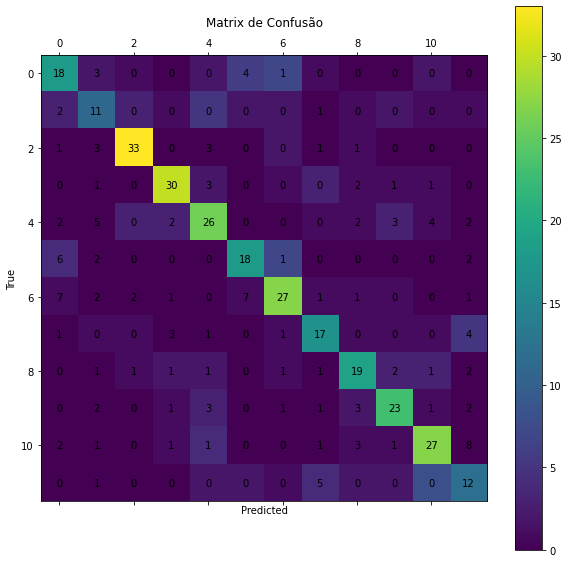

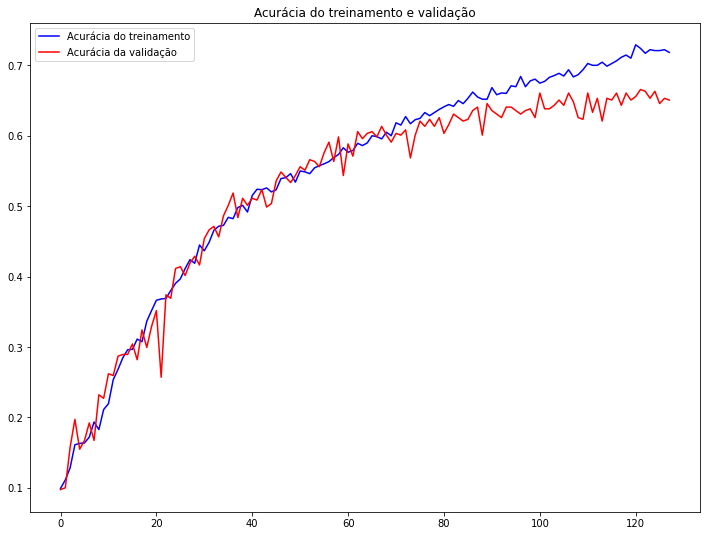

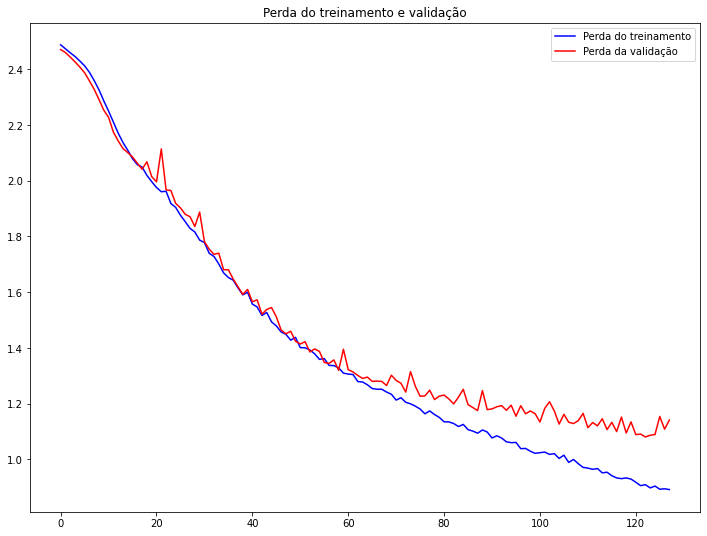

Execution Time: 15.629
EXECUÇÃO - DONE


In [9]:
## Star Time
checkpoint_time = get_time()

## Definitions
NUM_CLASSES = 12
IMG_ROWS = 20
IMG_COLS = 20
EPOCHS = 128

## Loading Inital Data
(x_train, y_train), (x_test, y_test) = load_dataset(TRAIN_FILE, TEST_FILE, resize=True, convert=True, size=(IMG_ROWS, IMG_COLS))

## Normalize images
x_train = normalize_images(x_train)
x_test = normalize_images(x_test)

## Generating Labels for Confusion Matrix
labels = generate_labels(x_test, y_test)

## Convert class vectros to binary class matrices
y_train = convert_vector(y_train, NUM_CLASSES)
y_test = convert_vector(y_test, NUM_CLASSES)

## Get LeNet 5 Model
model = lenet5(IMG_ROWS, IMG_COLS, NUM_CLASSES)

## Printing Summary
model.summary()

## Compiling Model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=["accuracy"])

## Trainning model
history = fit_model(model, x_train, y_train, x_test, y_test, EPOCHS)

## Getting Score
score = model.evaluate(x_test, y_test, verbose=0)

## Loss
print('Loss:', score[0])

## Accuracy
print('Accuracy:', score[1])

## Confusion Matrix
cm = get_confusion_matrix(model, x_test, labels)
print(f'Confusion Matrix: \n', cm)
plot_confusion_matrix(cm)

## Graphs
plot_graphs(history)

## Execution Time
print(f'Execution Time: {get_time_diff(checkpoint_time)}')

print('EXECUÇÃO - DONE')

# OUTRO MODELO CNN - SEM DATA AUGMENTATION

## EXECUÇÃO

Size: (64, 64)
Loading training set...
Loading testing set...
Resizing images...
(1578, 64, 64, 3)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               7372928   
_____________________

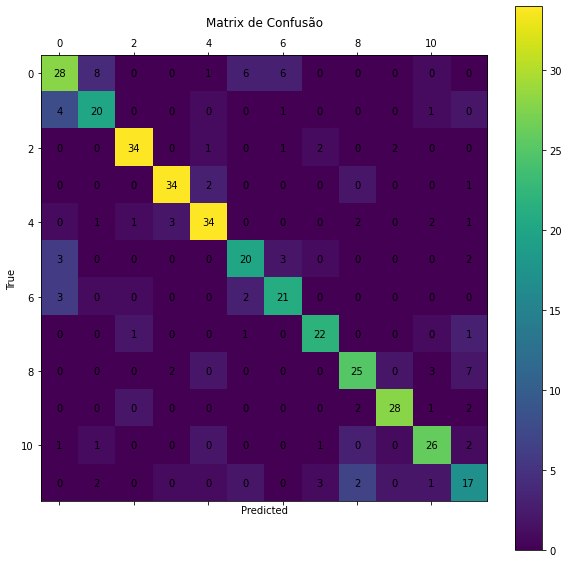

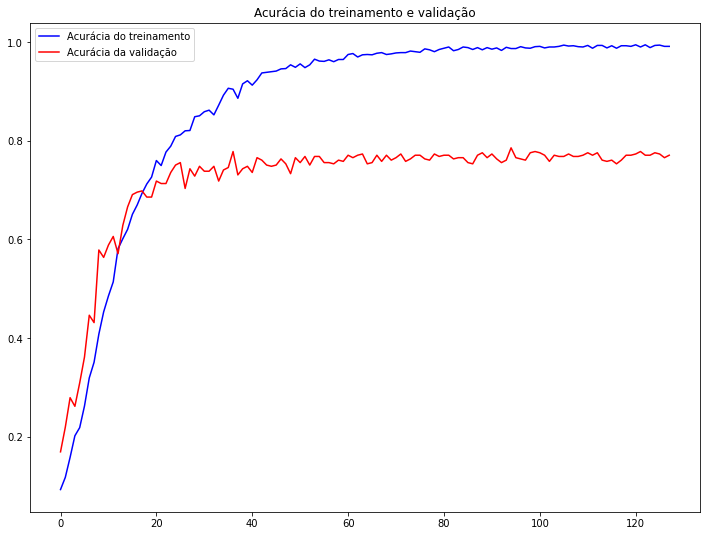

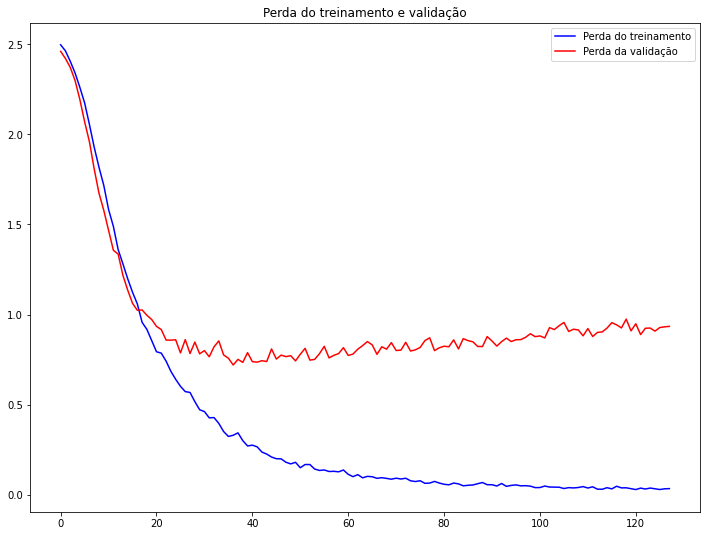

Execution Time: 39.874
EXECUÇÃO - DONE


In [10]:
## Star Time
checkpoint_time = get_time()

## Definitions
NUM_CLASSES = 12
IMG_ROWS = 64
IMG_COLS = 64
EPOCHS = 128

## Loading Inital Data
(x_train, y_train), (x_test, y_test) = load_dataset(TRAIN_FILE, TEST_FILE, resize=True, convert=True, size=(IMG_ROWS, IMG_COLS))

## Normalize images
x_train = normalize_images(x_train)
x_test = normalize_images(x_test)

## Generating Labels for Confusion Matrix
labels = generate_labels(x_test, y_test)

## Convert class vectros to binary class matrices
y_train = convert_vector(y_train, NUM_CLASSES)
y_test = convert_vector(y_test, NUM_CLASSES)

## Get LeNet 5 Model
model = default(IMG_ROWS, IMG_COLS, NUM_CLASSES)

## Printing Summary
model.summary()

## Compiling Model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=["accuracy"])

## Trainning model
history = fit_model(model, x_train, y_train, x_test, y_test, EPOCHS)

# Getting Score
score = model.evaluate(x_test, y_test, verbose=0)

# Loss
print('Loss:', score[0])

# Accuracy
print('Accuracy:', score[1])

## Confusion Matrix
cm = get_confusion_matrix(model, x_test, labels)
print(f'Confusion Matrix: \n', cm)
plot_confusion_matrix(cm)

# Graphs
plot_graphs(history)

## Execution Time
print(f'Execution Time: {get_time_diff(checkpoint_time)}')

print('EXECUÇÃO - DONE')


# IMPLEMENTANDO DATA AUGMENTATION

## CRIANDO OS DIRETÓRIOS


In [11]:
!mkdir ./data/data/all
!mkdir ./data/data/brightness
!mkdir ./data/data/flip
!mkdir ./data/data/rotation
!mkdir ./data/data/shift
!mkdir ./data/data/zoom
!touch ./data/train-aug.txt

mkdir: cannot create directory ‘./data/data/all’: File exists
mkdir: cannot create directory ‘./data/data/brightness’: File exists
mkdir: cannot create directory ‘./data/data/flip’: File exists
mkdir: cannot create directory ‘./data/data/rotation’: File exists
mkdir: cannot create directory ‘./data/data/shift’: File exists
mkdir: cannot create directory ‘./data/data/zoom’: File exists


## GERANDO AS NOVAS IMAGENS

In [ ]:
## Star Time
checkpoint_time = get_time()

drive_path = './'
aug_path = drive_path + "data/data"
train_file_aug = drive_path + 'data/train-aug.txt'

def replace(file_path, pattern):
    #Create temp file
    fh, abs_path = mkstemp()
    with fdopen(fh,'w') as new_file:
        with open(file_path) as old_file:
            for line in old_file:
                if pattern in line:
                    continue
                new_file.write(line)
    #Copy the file permissions from the old file to the new file
    copymode(file_path, abs_path)
    #Remove original file
    remove(file_path)
    #Move new file
    move(abs_path, file_path)

def save_to_aug(label, subdir):

    list_of_files = glob.glob(drive_path + "data/data/" + subdir + "/*")  # * means all if need specific format then *.csv

    if len(list_of_files) > 0:
        latest_file = max(list_of_files, key=os.path.getctime)
        replace(train_file_aug, latest_file.replace(aug_path + "/", ""))
        arq_aug = open(train_file_aug, "a+")
        arq_aug.write(latest_file.replace(aug_path + "/", "") + " " + label + "\n")
        arq_aug.close()


def flip_rotation_brightness_zoom(path, zoom=[0.5, 1.0], brightness=[0.2, 1.0], rotation=90, flip_horizontal=False,
                                  flip_vertical=False, subdir="zoom"):
    path, label = path.split(' ')
    path = drive_path + 'data/data/' + path
    img = load_img(path)
    # convert to numpy array
    data = img_to_array(img)
    # expand dimension to one sample
    samples = expand_dims(data, 0)
    # create image data augmentation generator
    datagen = ImageDataGenerator(zoom_range=zoom, brightness_range=brightness, rotation_range=rotation,
                                 horizontal_flip=flip_horizontal,vertical_flip=flip_vertical)
    # prepare iterator
    it = datagen.flow(samples, save_to_dir= aug_path + "/" + subdir + "/", batch_size=1)
    save_to_aug(label, subdir)
    # generate samples and plot
    for i in range(1):
        # define subplot
        plt.subplot(330 + 1 + i)
        # generate batch of images
        batch = it.next()
        # convert to unsigned integers for viewing
        image = batch[0].astype('uint8')
        # plot raw pixel data
        plt.imshow(image)
    # show the figure
    # plt.show()


def random_zoom(path, zoom=[0.5, 1.0], subdir="zoom"):
    path, label = path.split(' ')
    path = drive_path + 'data/data/' + path
    img = load_img(path)
    # convert to numpy array
    data = img_to_array(img)
    # expand dimension to one sample
    samples = expand_dims(data, 0)
    # create image data augmentation generator
    datagen = ImageDataGenerator(zoom_range=zoom)
    # prepare iterator
    it = datagen.flow(samples, save_to_dir= aug_path + "/" + subdir + "/", batch_size=1)
    save_to_aug(label, subdir)
    # generate samples and plot
    for i in range(1):
        # define subplot
        plt.subplot(330 + 1 + i)
        # generate batch of images
        batch = it.next()
        # convert to unsigned integers for viewing
        image = batch[0].astype('uint8')
        # plot raw pixel data
        plt.imshow(image)
    # show the figure
    #plt.show()


def random_brightness(path, brightness=[0.2, 1.0], subdir="brightness"):
    path, label = path.split(' ')
    path = drive_path + 'data/data/' + path
    # load the image
    img = load_img(path)
    # convert to numpy array
    data = img_to_array(img)
    # expand dimension to one sample
    samples = expand_dims(data, 0)
    # create image data augmentation generator
    datagen = ImageDataGenerator(brightness_range=brightness)
    # prepare iterator
    it = datagen.flow(samples, save_to_dir= aug_path + "/" + subdir + "/", batch_size=1)
    save_to_aug(label, subdir)
    # generate samples and plot
    for i in range(1):
        # define subplot
        plt.subplot(330 + 1 + i)
        # generate batch of images
        batch = it.next()
        # convert to unsigned integers for viewing
        image = batch[0].astype('uint8')
        # plot raw pixel data
        plt.imshow(image)
    # show the figure
    #plt.show()


def random_rotation(path, rotation=90, subdir="rotation"):
    path, label = path.split(' ')
    path = drive_path + 'data/data/' + path
    img = load_img(path)
    # convert to numpy array
    data = img_to_array(img)
    # expand dimension to one sample
    samples = expand_dims(data, 0)
    # create image data augmentation generator
    datagen = ImageDataGenerator(rotation_range=rotation)
    # prepare iterator
    it = datagen.flow(samples, save_to_dir= aug_path + "/" + subdir + "/", batch_size=1)
    save_to_aug(label, subdir)
    # generate samples and plot
    for i in range(1):
        # define subplot
        plt.subplot(330 + 1 + i)
        # generate batch of images
        batch = it.next()
        # convert to unsigned integers for viewing
        image = batch[0].astype('uint8')
        # plot raw pixel data
        plt.imshow(image)
    # show the figure
    #plt.show()


def horizontal_vertical_flip(path, flip_horizontal=False, flip_vertical=False, subdir="flip"):
    path, label = path.split(' ')
    path = drive_path + 'data/data/' + path
    # load the image
    img = load_img(path)
    # convert to numpy array
    data = img_to_array(img)
    # expand dimension to one sample
    samples = expand_dims(data, 0)
    # create image data augmentation generator
    datagen = ImageDataGenerator(horizontal_flip=flip_horizontal,vertical_flip=flip_vertical)
    # prepare iterator
    it = datagen.flow(samples, save_to_dir= aug_path + "/" + subdir + "/", batch_size=1)
    save_to_aug(label, subdir)
    # generate samples and plot
    for i in range(1):
        # define subplot
        plt.subplot(330 + 1 + i)
        # generate batch of images
        batch = it.next()
        # convert to unsigned integers for viewing
        image = batch[0].astype('uint8')
        # plot raw pixel data
        plt.imshow(image)
    # show the figure
    #plt.show()


def horizontal_vertical_shift(path, size=0.5, bool_width=True, subdir="shift"):
    path, label = path.split(' ')
    path = drive_path + 'data/data/' + path
    # load the image
    img = load_img(path)
    # convert to numpy array
    data = img_to_array(img)
    # expand dimension to one sample
    samples = expand_dims(data, 0)
    # create image data augmentation generator
    if bool_width:
        datagen = ImageDataGenerator(width_shift_range=size)
    else:
        datagen = ImageDataGenerator(height_shift_range=size)
    # prepare iterator
    it = datagen.flow(samples, save_to_dir= aug_path + "/" + subdir + "/", batch_size=1)
    save_to_aug(label, subdir)
    # generate samples and plot
    for i in range(1):
        # define subplot
        plt.subplot(330 + 1 + i)
        # generate batch of images
        batch = it.next()
        # convert to unsigned integers for viewing
        image = batch[0].astype('uint8')
        # plot raw pixel data
        plt.imshow(image)
    # show the figure
    #plt.show()


# Train and Test files
train_file = drive_path + 'data/train.txt'

arq = open(train_file, 'r')
texto = arq.read()
train_paths = texto.split('\n')
train_paths.remove('')  # Remove empty lines
train_paths.sort()

for image_path in train_paths:
  print(image_path)
  horizontal_vertical_flip(image_path, flip_horizontal=True, flip_vertical=False)
  horizontal_vertical_flip(image_path, flip_horizontal=False, flip_vertical=True)
  horizontal_vertical_flip(image_path, flip_horizontal=True, flip_vertical=True)
  horizontal_vertical_flip(image_path, flip_horizontal=False, flip_vertical=False)
  horizontal_vertical_shift(image_path, bool_width=True)
  horizontal_vertical_shift(image_path, bool_width=False)
  random_rotation(image_path, rotation=10)
  random_rotation(image_path, rotation=20)
  random_rotation(image_path, rotation=30)
  random_rotation(image_path, rotation=45)
  random_brightness(image_path)
  random_brightness(image_path, brightness=[0.1, 0.2])
  random_brightness(image_path, brightness=[0.3, 0.4])
  random_brightness(image_path, brightness=[0.4, 0.5])
  random_zoom(image_path)
  random_zoom(image_path, zoom=[0.1, 0.5])
  random_zoom(image_path, zoom=[0.1, 0.2])
  random_zoom(image_path, zoom=[0.1, 0.3])
  flip_rotation_brightness_zoom(image_path, rotation=30)
  flip_rotation_brightness_zoom(image_path, zoom=[0.1, 0.5], brightness=[0.1, 0.5])
  flip_rotation_brightness_zoom(image_path, zoom=[0.1, 0.5], brightness=[0.1, 0.5])
  flip_rotation_brightness_zoom(image_path, zoom=[0.1, 0.5], brightness=[0.1, 0.5], rotation=30)
  flip_rotation_brightness_zoom(image_path, zoom=[0.1, 0.5], brightness=[0.1, 0.5], rotation=30)
  flip_rotation_brightness_zoom(image_path, zoom=[0.1, 0.5], brightness=[0.1, 0.5], rotation=30)
  flip_rotation_brightness_zoom(image_path, zoom=[0.1, 0.8], brightness=[0.1, 0.8], rotation=45)
  flip_rotation_brightness_zoom(image_path, zoom=[0.1, 0.8], brightness=[0.1, 0.8], rotation=45)
  flip_rotation_brightness_zoom(image_path, zoom=[0.1, 0.2], brightness=[0.1, 0.2], rotation=30)
  flip_rotation_brightness_zoom(image_path, zoom=[0.1, 0.2], brightness=[0.1, 0.2], rotation=45)
  flip_rotation_brightness_zoom(image_path, zoom=[0.9, 1], brightness=[0.9, 1], rotation=30)
  flip_rotation_brightness_zoom(image_path, zoom=[0.9, 1], brightness=[0.9, 1], rotation=45)

## Execution Time
print(f'Execution Time: {get_time_diff(checkpoint_time)}')

print('GERANDO AS NOVAS IMAGENS - DONE')

AD0071.jpg 2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:195: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versi

AD0072.jpg 2
AD0073.jpg 2
AD0074.jpg 2
AD0075.jpg 2
AD0076.jpg 2
AD0077.jpg 2
AD0078.jpg 2
AD0079.jpg 2
AD0080.jpg 2
AD0081.jpg 2
AD0082.jpg 2
AD0084.jpg 2
AD0085.jpg 2
AD0086.jpg 2
AD0087.jpg 2
AD0088.jpg 2
AD0089.jpg 2
AD0090.jpg 2
AD0091.jpg 3
AD0092.jpg 3
AD0093.jpg 3
AD0094.jpg 3
AD0095.jpg 3
AD0096.jpg 3
AD0097.jpg 3
AD0098.jpg 3
AD0099.jpg 3
AD0100.jpg 3
AD0101.jpg 3
AD0102.jpg 3
AD0103.jpg 3
AD0104.jpg 3
AD0105.jpg 3
AD0106.jpg 3
AD0107.jpg 3
AD0108.jpg 3
AD0109.jpg 3
AD0110.jpg 3
AD0111.jpg 3
AD0112.jpg 3
AD0113.jpg 3
AD0114.jpg 3
AD0115.jpg 3
AD0116.jpg 3
AD0117.jpg 3
AD0118.jpg 3
AD0119.jpg 3
AD0120.jpg 3
AD0121.jpg 4
AD0122.jpg 4
AD0123.jpg 4
AD0124.jpg 4
AD0125.jpg 4
AD0126.jpg 4
AD0127.jpg 4
AD0128.jpg 4
AD0129.jpg 4
AD0130.jpg 4
AD0131.jpg 4
AD0132.jpg 4
AD0133.jpg 4
AD0135.jpg 4
AD0136.jpg 4
AD0137.jpg 4
AD0138.jpg 4
AD0139.jpg 4
AD0140.jpg 4
AD0141.jpg 4
AD0142.jpg 4
AD0143.jpg 4
AD0144.jpg 4
AD0145.jpg 4
AD0146.jpg 4
AD0147.jpg 4
AD0148.jpg 4
AD0149.jpg 4
AD0150.jpg 4

## JUNTANDO OS DADOS GERADOS COM OS INICIAIS

In [ ]:
import shutil

TRAIN_AUG_FILE = './data/train-aug.txt'
TRAIN_FINAL = './data/train-final.txt'

def mergeTrainFiles():
  filenames = [TRAIN_FILE, TRAIN_AUG_FILE]
  with open(TRAIN_FINAL, 'w') as outfile:
      for fname in filenames:
          with open(fname) as infile:
              for line in infile:
                  outfile.write(line)

mergeTrainFiles()

print('JUNTANDO OS DADOS GERADOS COM OS INICIAIS - DONE')

# LENET 5 - COM DATA AUGMENTATION

## EXECUÇÃO

In [ ]:
## Star Time
checkpoint_time = get_time()

## Definitions
NUM_CLASSES = 12
IMG_ROWS = 32
IMG_COLS = 32
EPOCHS = 32

## Loading Inital Data
(x_train, y_train), (x_test, y_test) = load_dataset(TRAIN_FINAL, TEST_FILE, resize=True, convert=True, size=(IMG_ROWS, IMG_COLS))

## Normalize images
x_train = normalize_images(x_train)
x_test = normalize_images(x_test)

## Generating Labels for Confusion Matrix
labels = generate_labels(x_test, y_test)

## Convert class vectros to binary class matrices
y_train = convert_vector(y_train, NUM_CLASSES)
y_test = convert_vector(y_test, NUM_CLASSES)

## Get LeNet 5 Model
model = lenet5(IMG_ROWS, IMG_COLS, NUM_CLASSES)

## Printing Summary
model.summary()

## Compiling Model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=["accuracy"])

## Trainning model
history = fit_model(model, x_train, y_train, x_test, y_test, EPOCHS)

## Getting Score
score = model.evaluate(x_test, y_test, verbose=0)

## Loss
print('Loss:', score[0])

## Accuracy
print('Accuracy:', score[1])

## Confusion Matrix
cm = get_confusion_matrix(model, x_test, labels)
print(f'Confusion Matrix: \n', cm)
plot_confusion_matrix(cm)

## Graphs
plot_graphs(history)

## Execution Time
print(f'Execution Time: {get_time_diff(checkpoint_time)}')

print('EXECUÇÃO - DONE')

# OUTRO MODELO CNN - COM DATA AUGMENTATION

## EXECUÇÃO

In [ ]:
## Star Time
checkpoint_time = get_time()

## Definitions

NUM_CLASSES = 12
IMG_ROWS = 64
IMG_COLS = 64
EPOCHS = 64

## Loading Inital Data
(x_train, y_train), (x_test, y_test) = load_dataset(TRAIN_FINAL, TEST_FILE, resize=True, convert=True, size=(IMG_ROWS, IMG_COLS))

## Normalize images
x_train = normalize_images(x_train)
x_test = normalize_images(x_test)

## Generating Labels for Confusion Matrix
labels = generate_labels(x_test, y_test)

## Convert class vectros to binary class matrices
y_train = convert_vector(y_train, NUM_CLASSES)
y_test = convert_vector(y_test, NUM_CLASSES)

## Get LeNet 5 Model
model = default(IMG_ROWS, IMG_COLS, NUM_CLASSES)

## Printing Summary
model.summary()

## Compiling Model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=["accuracy"])

## Trainning model
history = fit_model(model, x_train, y_train, x_test, y_test, EPOCHS)

## Getting Score
score = model.evaluate(x_test, y_test, verbose=0)

## Loss
print('Loss:', score[0])

## Accuracy
print('Accuracy:', score[1])

## Confusion Matrix
cm = get_confusion_matrix(model, x_test, labels)
print(f'Confusion Matrix: \n', cm)
plot_confusion_matrix(cm)

## Graphs
plot_graphs(history)

## Execution Time
print(f'Execution Time: {get_time_diff(checkpoint_time)}')

print('EXECUÇÃO - DONE')

# EXTRAÇÃO DE CARACTERÍSTICAS

## CRIANDO OS DIRETÓRIOS E ARQUIVOS

In [ ]:
!mkdir ./data/svm
!touch ./data/svm/test.svm
!touch ./data/svm/train.svm

## EXTRAINDO AS CARACTERÍSTICAS

In [ ]:
## Star Time
checkpoint_time = get_time()

INPUT_FILE_TEST = "./data/test.txt"
OUTPUT_FILE_TEST = "./data/svm/test.svm"
INPUT_FILE_TRAIN = TRAIN_FINAL
OUTPUT_FILE_TRAIN = "./data/svm/train.svm"
IMG_ROWS = 100
IMG_COLS = 100
DIR_DATASET = "./data/data/"

# Train
extract_features(INPUT_FILE_TRAIN, OUTPUT_FILE_TRAIN, IMG_ROWS, IMG_COLS, DIR_DATASET)

# Test
extract_features(INPUT_FILE_TEST, OUTPUT_FILE_TEST, IMG_ROWS, IMG_COLS, DIR_DATASET)

## Execution Time
print(f'Execution Time: {get_time_diff(checkpoint_time)}')

print('EXTRAINDO AS CARACTERÍSTICAS - DONE')

# IMPLEMENTANDO O SVM

In [ ]:
## Star Time
checkpoint_time = get_time()

INPUT_TRAIN = "./data/svm/train.svm"
INPUT_TEST = "./data/svm/test.svm"

x_train, y_train = load_svmlight_file(INPUT_TRAIN)
x_test, y_test = load_svmlight_file(INPUT_TEST)

x_train = x_train.toarray()
x_test = x_test.toarray()

classificator = svm.SVC()
classificator.fit(x_train, y_train)
predict = classificator.predict(x_test)
f1_score = round_float(sklearn_f1_score(y_test, predict, labels=np.unique(predict), average='weighted'))
accuracy = round_float(accuracy_score(y_test, predict))
cm = confusion_matrix(y_test, predict)

print(f'Accuracy:  {accuracy}')
print(f'F1Score:  {f1_score}')

## Confusion Matrix
cm = get_confusion_matrix(model, x_test, labels)
print(f'Confusion Matrix: \n', cm)
plot_confusion_matrix(cm)

## Execution Time
print(f'Execution Time: {get_time_diff(checkpoint_time)}')

print('IMPLEMENTANDO O SVM - DONE')